In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import warnings

In [2]:
# Suppressing warnings
warnings.filterwarnings("ignore")

set_style("whitegrid")

# Loading the dataset
data_aap = pd.read_csv("data/individual_stocks_5yr/individual_stocks_5yr/AAP_data.csv",
                        parse_dates=['date'])
data_aap.drop(columns=['open', 'high', 'low', 'Name', 'volume'], inplace=True)
data_aap.head()

,date,close
0,2013-02-08,78.90
1,2013-02-11,78.39
2,2013-02-12,78.60
3,2013-02-13,78.97
4,2013-02-14,78.84


In [3]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_aap_scaled = data_aap.copy()
data_aap_scaled['close'] = scaler.fit_transform(data_aap_scaled[['close']])
data_aap_scaled.head()


,date,close
0,2013-02-08,0.021900
1,2013-02-11,0.017794
2,2013-02-12,0.019485
3,2013-02-13,0.022464
4,2013-02-14,0.021417


In [4]:
# Time Series Cross-Validation
n_splits = 5
tscv = np.array_split(data_aap_scaled, n_splits) #this splits the data (scaled) into n parts


In [5]:
#Prediction Methods
reg = LinearRegression()

#Sliding Windows
def sliding_window(data,window_size):    
    predictions = []
    for k in range(window_size):
        predictions.append(0)        
    for k in range(window_size-1, len(data)-1):
        y_sw = data.iloc[k - (window_size - 1):k + 1]['close'] #This is the window of data
        reg.fit(np.arange(window_size).reshape(-1, 1), y_sw) #This is the "creation" of the line
        predictions.append(reg.predict([[window_size]])[0]) #This appends the prediction to a list.
    return(predictions)

#Naive Prediction
def naive_prediction(data):
    return sliding_window(data,1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


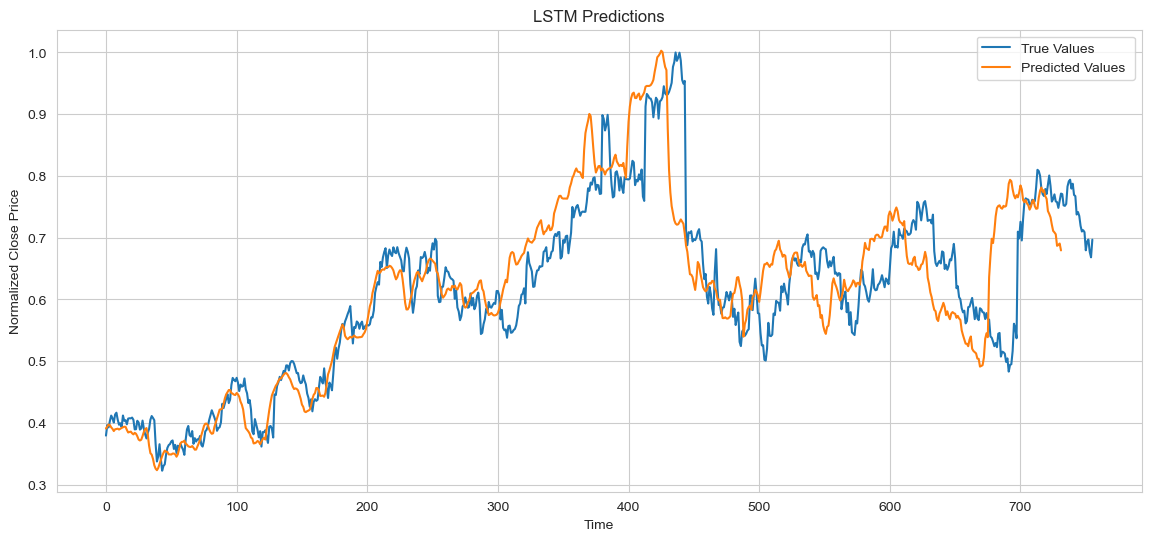

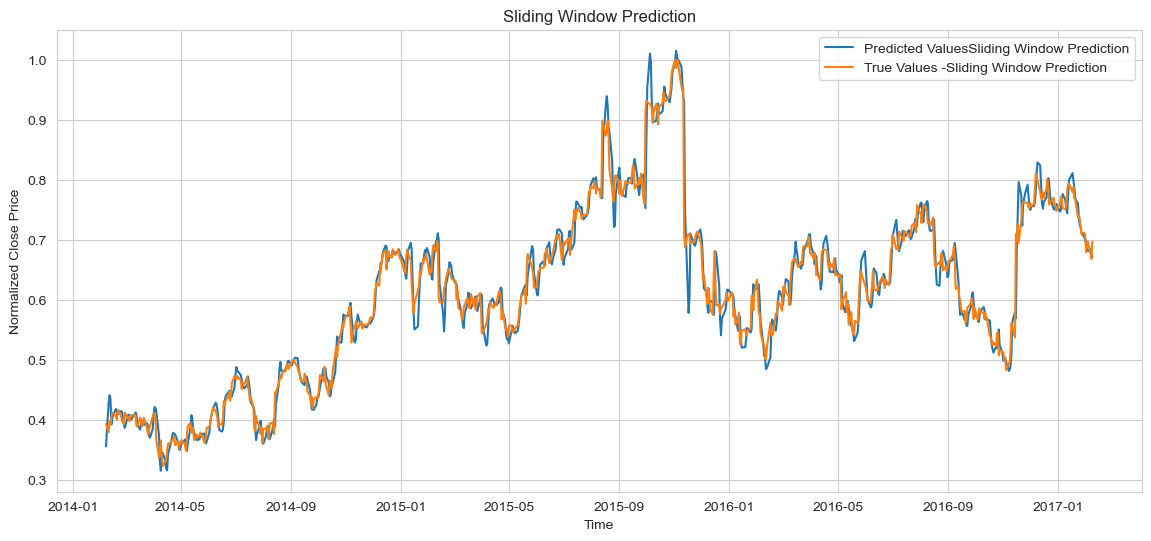

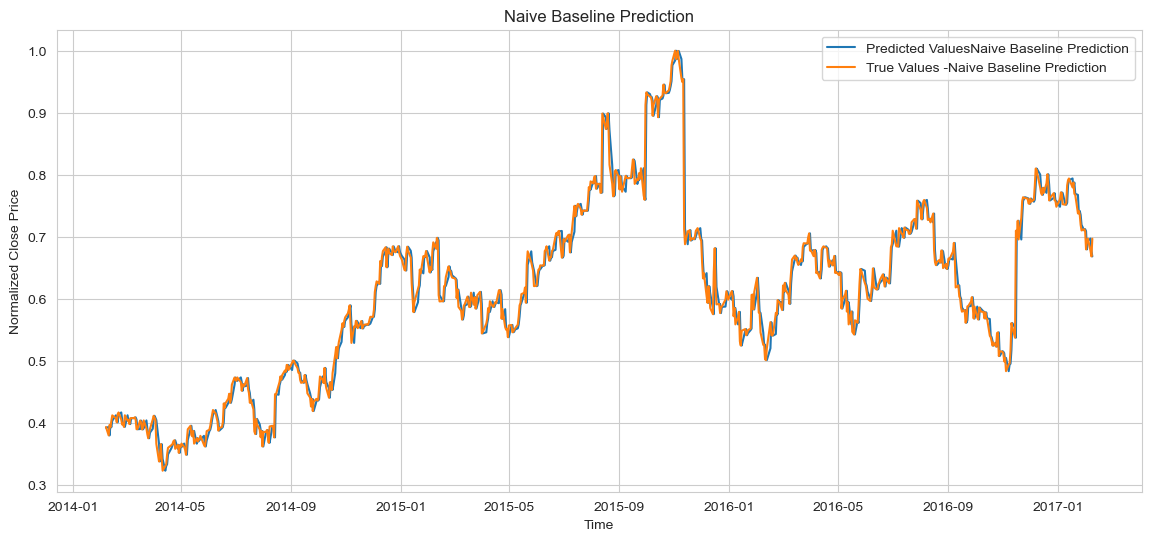

In [43]:
# LSTM Model with Time Series Cross-Validation
def lstm_cross_validation(window_length, n_splits):
    mse_scores = []
    all_val_predictions = []
    
    for i in range(1,n_splits-1):       
        train_data = pd.concat(tscv[:i]) # Combining training sets
        val_data = tscv[i]

        # Preparing for training and validation
        scaled_train = train_data['close'].to_numpy().reshape(-1, 1)
        scaled_val = val_data['close'].to_numpy().reshape(-1, 1)
        
        # Creating sequences for LSTM
        trainX, trainY = [], []
        for j in range(len(scaled_train) - window_length - 1):
            trainX.append(scaled_train[j:j + window_length])
            trainY.append(scaled_train[j + window_length, 0])
        trainX, trainY = np.array(trainX), np.array(trainY)

        valX, valY = [], []
        for j in range(len(scaled_val) - window_length - 1):
            valX.append(scaled_val[j:j + window_length])
            valY.append(scaled_val[j + window_length, 0])
        valX, valY = np.array(valX), np.array(valY)

        # Reshaping data for LSTM input
        trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2])
        valX = valX.reshape(valX.shape[0], valX.shape[1], valX.shape[2])

        # Building the LSTM model
        model = Sequential()
        model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        # Training the model and making predictions
        model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=0)
        val_predictions = model.predict(valX)

        # Calculating MSE and store predictions
        mse = mean_squared_error(valY, val_predictions)
        mse_scores.append(mse)
        all_val_predictions.extend(val_predictions.flatten())

    # Returning average MSE and all predictions
    return np.mean(mse_scores), all_val_predictions

val_mse_lstm, val_predictions_lstm = lstm_cross_validation(7, n_splits)

# Plotting LSTM Predictions
validation_data = pd.concat(tscv[1:n_splits-1])['close']

plt.figure(figsize=(14, 6))
plt.plot(validation_data.values, label='True Values')
plt.plot(np.array(val_predictions_lstm), label='Predicted Values ')
plt.title('LSTM Predictions')
plt.xlabel('Time')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.show()

def sliding_window_plot(data,window_size,string = 'Sliding Window Prediction'):
    L = len(tscv[n_splits-1])
    validation_predictions = sliding_window(data,window_size)[:len(data)-L]
    plt.figure(figsize=(14, 6))
    plt.plot(data['date'][L:len(data)-L],validation_predictions[L:], label='Predicted Values'+ string)
    plt.plot(data['date'][L:len(data)-L],data['close'][L:len(data)-L], label='True Values -'+ string )
    plt.title(string)
    plt.xlabel('Time')
    plt.ylabel('Normalized Close Price')
    plt.legend()
    plt.show()

def naive_prediction_plot(data, string = 'Naive Baseline Prediction'):
    sliding_window_plot(data,1,string)

sliding_window_plot(data_aap_scaled,5)

naive_prediction_plot(data_aap_scaled)

In [44]:
#Time Series Cross Validation on Each Method


def sliding_window_tscv(window_size,n_splits):
    mse_scores = []
    for i in range(1,n_splits-1):
        data_tscv = pd.concat(tscv[:i+1])
        train = pd.concat(tscv[:i])
        val = tscv[i]
        val_predictions = sliding_window(data_tscv, window_size)[len(train):len(data_tscv)]
        mse_scores.append( mean_squared_error(val['close'] , val_predictions) )
    return(np.mean(mse_scores))
val_mse_sw = sliding_window_tscv(5,n_splits)


print('Sliding Window Linear Regression Validation MSE: {:.10f}'.format(val_mse_sw))
print('LSTM Validation MSE: {:.10f}'.format(val_mse_lstm))

def naive_tscv(n_splits):
    return(sliding_window_tscv(1,n_splits))
val_mse_naive = naive_tscv(n_splits) 

print('Naive Baseline Validation MSE: {:.10f}'.format(val_mse_naive))

Sliding Window Linear Regression Validation MSE: 0.0006860830
LSTM Validation MSE: 0.0009234570
Naive Baseline Validation MSE: 0.0004448177


In [48]:
min_mse = min(val_mse_sw, val_mse_lstm, val_mse_naive)

if min_mse == val_mse_sw:
    print('The Sliding Window Linear Regression Model is better with a Validation MSE of {:.10f}'.format(val_mse_sw))
elif min_mse == val_mse_lstm:
    print('The LSTM Model is better with a Validation MSE of {:.10f}'.format(val_mse_lstm))
else:
    print('The Naive Baseline Model is best with a Validation MSE of {:.10f}'.format(val_mse_naive))

The Naive Baseline Model is best with a Validation MSE of 0.0004448177


In [49]:
test = naive_prediction(data_aap_scaled)[-len(tscv[n_splits-1]): ]
test_mse_naive = mean_squared_error( data_aap_scaled['close'][-len(tscv[n_splits-1]): ] , test) 
print('Naive Baseline Test MSE: {:.10f}'.format(val_mse_naive))


Naive Baseline Test MSE: 0.0004448177
